<a href="https://colab.research.google.com/github/AnguillaJaponica/Qin2016/blob/master/Qin2016_neupy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [228]:
!pip install neupy

In [229]:
from sklearn import preprocessing
import pandas as pd
import numpy as np
import tensorflow as tf
import scipy.stats
from matplotlib import pyplot as plt
from matplotlib import cm
from neupy.layers import *
from neupy import algorithms

In [230]:
# google driveをマウント。ファイルを置く場所に応じて、ディレクトリを変えてください。今はルートになってます。
from google.colab import drive
drive.mount('/content/drive')

all_data = pd.read_csv('drive/My Drive/all_table3.csv') 
# 元のcsvが扱いづらかったので、a, b, cのカラムを分けてクエリっぽく使ってます。
train_data = all_data[all_data['group'] == 'a']
validation_data = all_data[all_data['group'] == 'b']
test_data = all_data[all_data['group'] == 'c']

# K値でやってみよう
# sklearnのpreprocessing.MinMaxScalerを使って正規化。デフォルトは(0, 1)なので、論文の定義どおり(-1, 1)で出してくれるようにしています。

# 訓練用
trainX_Kvalue = preprocessing.MinMaxScaler(feature_range=(-1,1)).fit_transform(np.array(pd.concat([train_data['Temperature(K)_Kvalue'], train_data['Time(h)_Kvalue']], axis=1)).reshape(30, 2))
trainY_Kvalue = preprocessing.MinMaxScaler(feature_range=(-1,1)).fit_transform(np.array(train_data['ΔK (%)']).reshape(-1, 1))
# バリデーション用
validationX_Kvalue = preprocessing.MinMaxScaler(feature_range=(-1,1)).fit_transform(np.array(pd.concat([validation_data['Temperature(K)_Kvalue'], validation_data['Time(h)_Kvalue']], axis=1)))
validationY_Kvalue = preprocessing.MinMaxScaler(feature_range=(-1,1)).fit_transform(np.array(validation_data['ΔK (%)']).reshape(-1, 1))
# テスト用
testX_Kvalue = preprocessing.MinMaxScaler(feature_range=(-1,1)).fit_transform(np.array(pd.concat([test_data['Temperature(K)_Kvalue'], test_data['Time(h)_Kvalue']], axis=1)))
testY_Kvalue = preprocessing.MinMaxScaler(feature_range=(-1,1)).fit_transform(np.array(test_data['ΔK (%)']).reshape(-1, 1))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [231]:
# 入力: [温度, 保存期間]
n_inputs = 2
# 出力: [K値]
n_outputs = 1

network = join(Input(n_inputs), Sigmoid(7), Linear(n_outputs))
# 最適化アルゴリズムはLM法。学習率muはチューニングしてみてください。
optimizer = algorithms.LevenbergMarquardt(network, verbose=True, show_epoch=5, mu=0.003)


Main information

[ALGORITHM] LevenbergMarquardt

[OPTION] loss = mse
[OPTION] mu = 0.003
[OPTION] mu_update_factor = 1.2
[OPTION] show_epoch = 5
[OPTION] shuffle_data = False
[OPTION] signals = None
[OPTION] target = Tensor("placeholder/target/linear-33:0", shape=(?, 1), dtype=float32)
[OPTION] verbose = True

[TENSORFLOW] Initializing Tensorflow variables and functions.
[TENSORFLOW] Initialization finished successfully. It took 12.97 seconds


In [232]:
optimizer.train(trainX_Kvalue, trainY_Kvalue, validationX_Kvalue, validationY_Kvalue, epochs=30)

#1 : [2 sec] train: 0.665953, valid: 1.410910
#5 : [4 ms] train: 0.511575, valid: 0.099510
#10 : [3 ms] train: 0.039746, valid: 0.354470
#15 : [3 ms] train: 0.018765, valid: 0.320377
#20 : [4 ms] train: 0.009849, valid: 0.514671
#25 : [4 ms] train: 0.008669, valid: 0.412855
#30 : [3 ms] train: 0.007646, valid: 0.352736


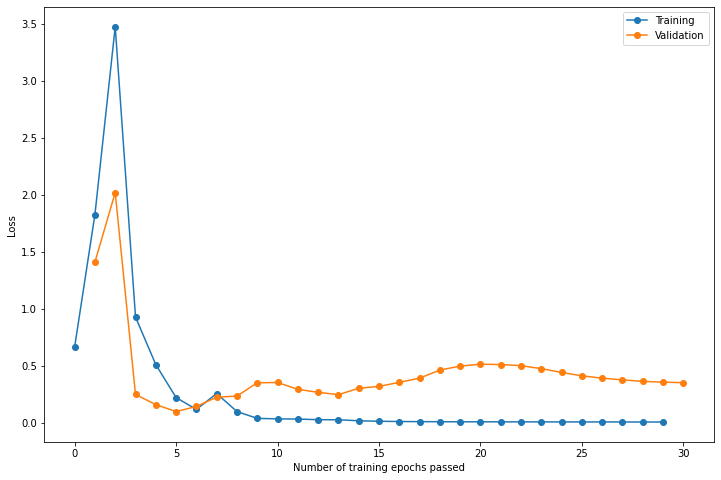

In [233]:
# 誤差をプロットして、チューニングしやすいようにする。
optimizer.plot_errors()

In [234]:
import numpy as np

def rmsle(expected, predicted):
    log_expected = np.log1p(expected + 1)
    log_predicted = np.log1p(predicted + 1)
    squared_log_error = np.square(log_expected - log_predicted)
    return np.sqrt(np.mean(squared_log_error))

# 予測結果
predicted_Kvalue_test = optimizer.predict(testX_Kvalue)
predicted_Kvalue_validation = optimizer.predict(validationX_Kvalue)
predicted_Kvalue_train = optimizer.predict(trainX_Kvalue)

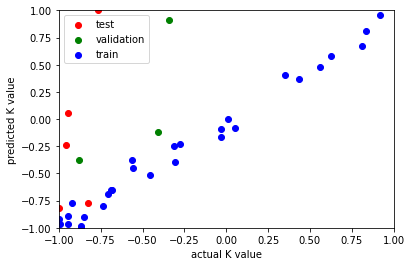

In [235]:
# train, validation, testそれぞれについて散布図をかく。
fig = plt.figure()
axis = fig.add_subplot(111, xlim=(-1, 1), ylim=(-1, 1), xlabel='actual K value', ylabel='predicted K value')
plt.scatter(testY_Kvalue, predicted_Kvalue_test, marker='o', label='test', color="red")
plt.scatter(validationY_Kvalue, predicted_Kvalue_validation, marker='o', label='validation', color="green")
plt.scatter(trainY_Kvalue, predicted_Kvalue_train, marker='o', label='train', color="blue")
plt.legend(loc='upper left')